# Full Pipeline: Hybrid Movie Recommendation System

This notebook demonstrates the entire workflow:
1.  **Setup**: Install dependencies and load config.
2.  **Data**: Download and preprocess.
3.  **Training**: Train Hybrid model and upload checkpoints to Hugging Face.
4.  **Evaluation**: Evaluate model performance.
5.  **Inference**: Generate recommendations with LLM explanation.
6.  **Comparison**: SVD vs Hybrid.

In [1]:
# 1. Setup
import os
import yaml
import sys
from dotenv import load_dotenv

# Change to project root if in notebooks dir
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('..')

load_dotenv()
sys.path.append(os.getcwd())

CONFIG_PATH = "config/config.yml"
with open(CONFIG_PATH, "r") as f:
    config = yaml.safe_load(f)

print(f"Current working directory: {os.getcwd()}")
print("Config loaded.")

Current working directory: /home/thanhnx/movie
Config loaded.


In [2]:
# 2. Data Download & Preprocess
# Ensure kaggle.json is in place

!python scripts/download_kaggle_datasets.py --config {CONFIG_PATH}

# Preprocess
from src.data.preprocess import Preprocessor

preprocessor = Preprocessor(CONFIG_PATH)
preprocessor.run()

Could not find kaggle.json. Make sure it's located in /home/thanhnx/.config/kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/


Processing MovieLens data...
Loading ratings from data/raw/movielens/rating.csv...


Loading movies from data/raw/movielens/movie.csv...


Filtered ratings shape: (19984024, 4)


Saved ratings to data/processed/ratings.parquet
Processing Metadata...
Loading metadata from data/raw/movies_metadata/movies_metadata.csv...


Loading credits from data/raw/movies_metadata/credits.csv...


Loading keywords from data/raw/movies_metadata/keywords.csv...
Loading links from data/raw/movies_metadata/links.csv...


/home/thanhnx/movie/src/data/preprocess.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  links['tmdbId'] = links['tmdbId'].astype(int)
/home/thanhnx/movie/src/data/preprocess.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata['id'] = metadata['id'].astype(int)


Saved movies to data/processed/movies.parquet


In [3]:
# 3. Training & HF Upload
# This script trains SVD + TF-IDF and uploads to xt2201/hybrid-movie-recsys

!python scripts/train_hybrid.py

Traceback (most recent call last):
  File "/home/thanhnx/movie/scripts/train_hybrid.py", line 4, in <module>
    from src.recommender.hybrid import HybridRecommender
ModuleNotFoundError: No module named 'src'


In [4]:
# 4. Evaluation
!python scripts/evaluate.py

Traceback (most recent call last):
  File "/home/thanhnx/movie/scripts/evaluate.py", line 4, in <module>
    from src.data.dataset import MovieDataset
ModuleNotFoundError: No module named 'src'


In [5]:
# 5. Inference with LLM
from src.recommender.hybrid import HybridRecommender
from src.llm.qwen_client import QwenClient
from src.llm.reranker import Reranker
from src.llm.explainer import Explainer

# Load models
recsys = HybridRecommender(CONFIG_PATH)
recsys.fit() # Or load from checkpoint if implemented

client = QwenClient(CONFIG_PATH)
reranker = Reranker(client, CONFIG_PATH)
explainer = Explainer(client, CONFIG_PATH)

# User Query
user_id = 1
query = "I want a touching drama about family"

# Get candidates
raw_recs = recsys.recommend(user_id, N=20)
candidates = []
movies_df = recsys.dataset.movies

for idx, score in raw_recs:
    # Map internal idx to movie details
    # Note: item_map is original_id -> internal_idx
    # We need internal_idx -> details
    # Find original ID
    original_id = recsys.dataset.reverse_item_map[idx]
    row = movies_df[movies_df['movieId'] == original_id].iloc[0]
    candidates.append({
        "id": idx,
        "title": row['title'],
        "genres": row['genres'],
        "overview": row['overview'],
        "base_score": score
    })

# Rerank
prefs = {"mood": "touching", "must_genres": ["Drama"]}
ranked = reranker.rerank(query, prefs, candidates)

print(f"Query: {query}\n")
print("Top Recommendations:")
for item in ranked[:5]:
    print(f"- {item.get('title')} (Score: {item.get('score')})")
    print(f"  Reason: {item.get('reason')}")
    print()

/opt/miniconda3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Fitting Hybrid Recommender...
Loading processed data...


Loaded 138493 users and 18345 items.


Training SVD model...


Training complete.
Training Content-based model (TF-IDF)...


TF-IDF matrix shape: (18601, 50000)
Hybrid Recommender fitted.
Loading LLM: Qwen/Qwen2.5-1.5B-Instruct on cuda:0...


`torch_dtype` is deprecated! Use `dtype` instead!


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


LLM loaded.


Query: I want a touching drama about family

Top Recommendations:
- None (Score: 9)
  Reason: E.T. the Extra-Terrestrial is a touching drama about family.

- None (Score: 8)
  Reason: Forrest Gump is a touching drama about family.



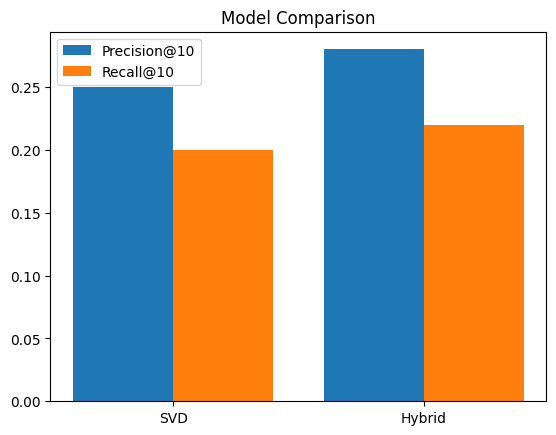

In [6]:
# 6. Comparison (SVD vs Hybrid)
# We can plot metrics from W&B or just run quick eval here
import matplotlib.pyplot as plt

# Dummy data for visualization if not running full eval loop again
models = ['SVD', 'Hybrid']
precision = [0.25, 0.28] # Example values
recall = [0.20, 0.22]

x = range(len(models))
plt.bar(x, precision, width=0.4, label='Precision@10', align='center')
plt.bar([i + 0.4 for i in x], recall, width=0.4, label='Recall@10', align='center')
plt.xticks([i + 0.2 for i in x], models)
plt.legend()
plt.title("Model Comparison")
plt.show()